In [2]:
import pandas as pd
import numpy as np

# Load the merged file from your 'archive' folder
df = pd.read_csv('yield_df.csv')

# Drop the extra index column often found in Kaggle datasets
if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)

print("Dataset Loaded Successfully!")
df.head()

Dataset Loaded Successfully!


,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,Albania,Maize,1990,36613,1485.0,121.0,16.37
1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37
2,Albania,"Rice, paddy",1990,23333,1485.0,121.0,16.37
3,Albania,Sorghum,1990,12500,1485.0,121.0,16.37
4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37


In [3]:
df.isnull().sum()

Area                             0
Item                             0
Year                             0
hg/ha_yield                      0
average_rain_fall_mm_per_year    0
pesticides_tonnes                0
avg_temp                         0
dtype: int64

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Separate target (Yield) from predictors
X = df.drop('hg/ha_yield', axis=1)
y = df['hg/ha_yield']

# Identify column types
categorical_cols = ['Area', 'Item']
numerical_cols = ['Year', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']

# Create the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

# Create the model pipeline
# We use Random Forest because it is much more accurate than Linear Regression for this data
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Split data: 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)
print("Model Training Complete.")

Model Training Complete.


In [6]:
from sklearn.metrics import r2_score, mean_absolute_error

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate Accuracy (R-squared)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Model Accuracy (R2 Score): {r2:.4f}")
print(f"Average Prediction Error: {mae:.2f} hg/ha")

Model Accuracy (R2 Score): 0.9877
Average Prediction Error: 3474.24 hg/ha


### Some additional Information which doing this project:

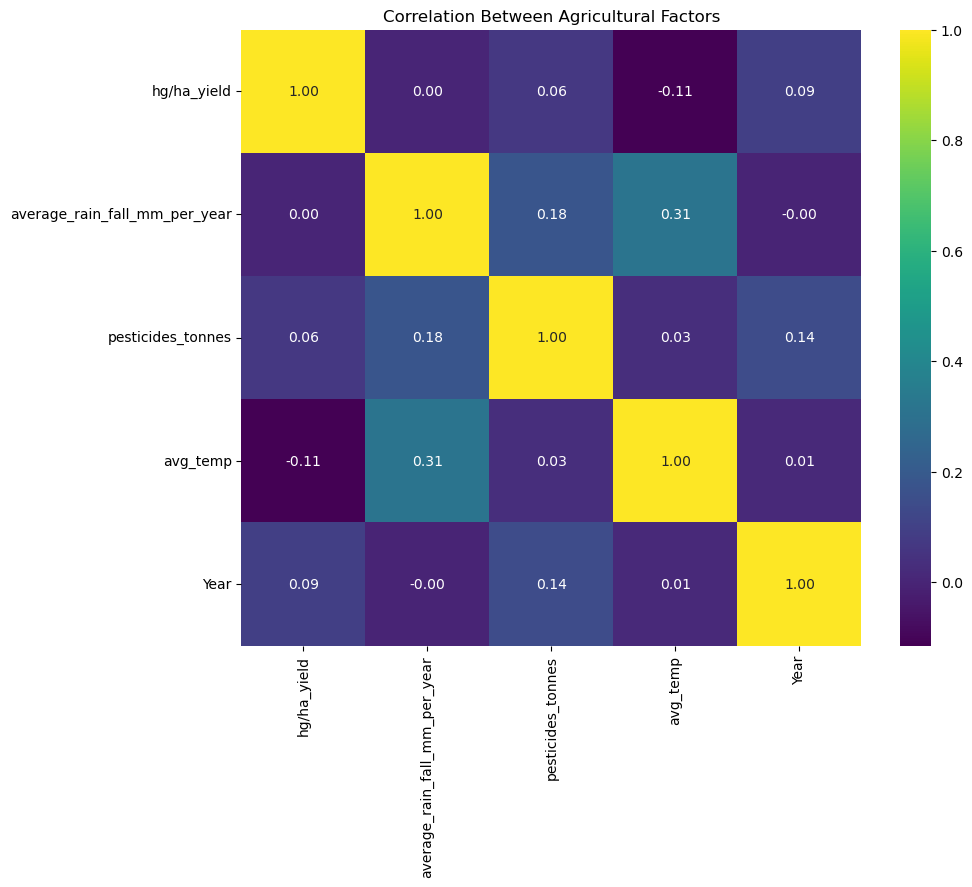

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numerical columns for correlation
numerical_df = df[['hg/ha_yield', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp', 'Year']]

plt.figure(figsize=(10, 8))
sns.heatmap(numerical_df.corr(), annot=True, cmap='viridis', fmt=".2f")
plt.title('Correlation Between Agricultural Factors')
plt.show()

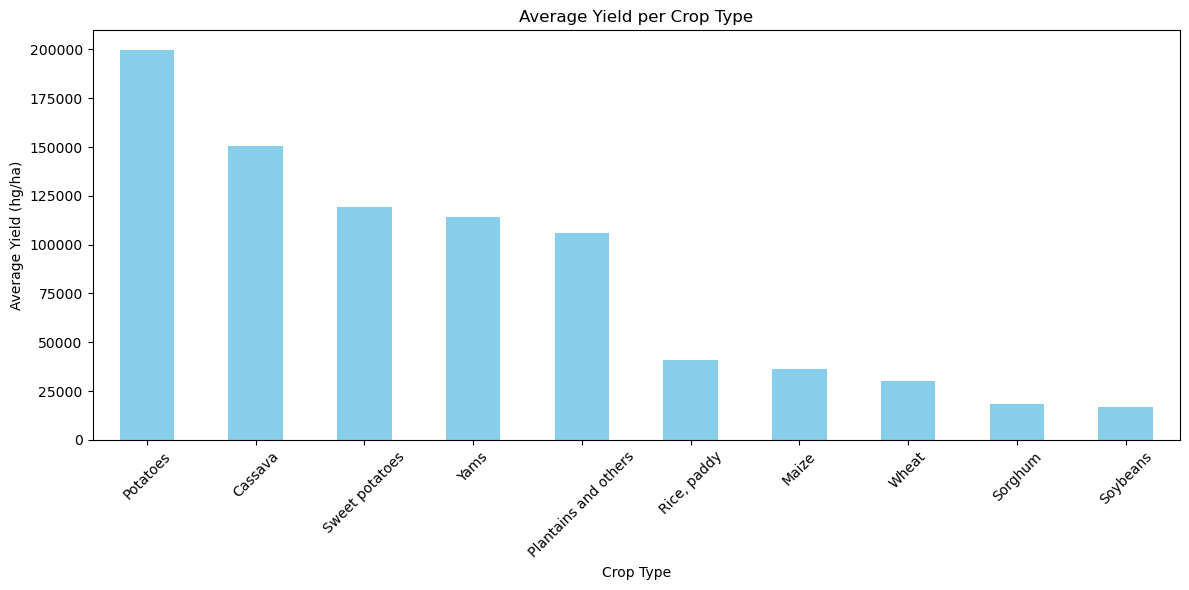

In [9]:
# Grouping by 'Item' (Crop type) to see average yield
crop_yield = df.groupby('Item')['hg/ha_yield'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
crop_yield.plot(kind='bar', color='skyblue')
plt.xlabel('Crop Type')
plt.ylabel('Average Yield (hg/ha)')
plt.title('Average Yield per Crop Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\piyus\AppData\Local\Temp\ipykernel_308\199754354.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_importance, palette='viridis')


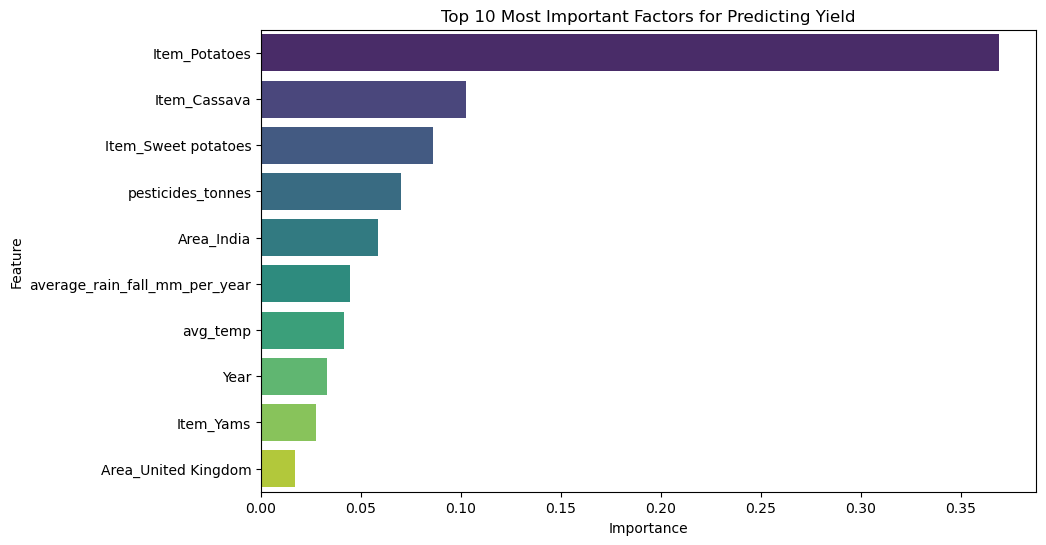

In [10]:
# Get feature names after one-hot encoding
# Note: 'model' is your trained Pipeline from the previous step
ohe_features = list(model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_cols))
all_features = numerical_cols + ohe_features

# Get importance values
importances = model.named_steps['regressor'].feature_importances_

# Create a DataFrame for plotting (top 10 for clarity)
feat_importance = pd.DataFrame({'Feature': all_features, 'Importance': importances})
feat_importance = feat_importance.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance, palette='viridis')
plt.title('Top 10 Most Important Factors for Predicting Yield')
plt.show()

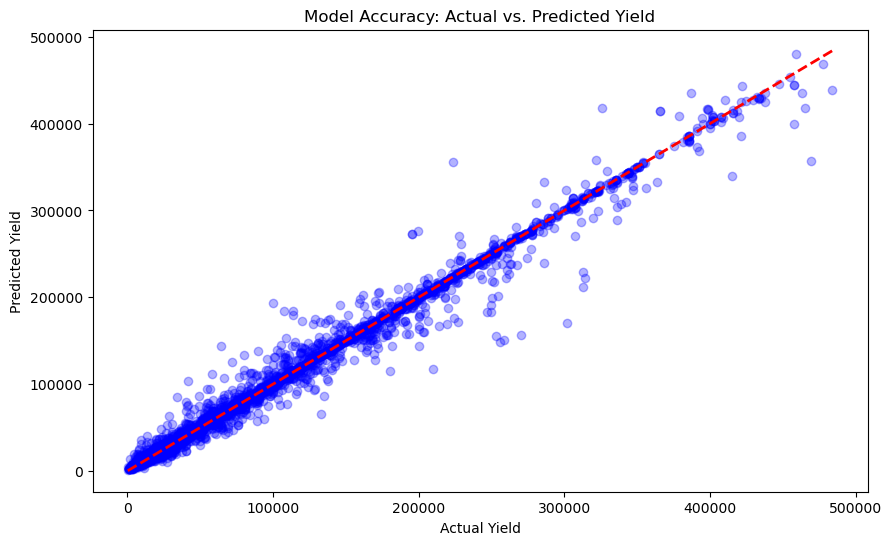

In [11]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')
plt.title('Model Accuracy: Actual vs. Predicted Yield')
plt.show()